In [ ]:
df = pd.read_csv('../../../Downloads/investments_VC.csv',encoding='latin1')
len(df.columns)
len(df)

In [35]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})
import folium
import re
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor


class DataFrame(object):

    def __init__(self,file_path):
        """Create df object
        Parameters
        ----------
        file_path: takes in a file path to raw data
        """
        self.file_path = file_path
        
    def clean(self):
        '''
        Parameters
            self: self
        Returns
            a cleaned df
        '''
        df = pd.read_csv(self.file_path,encoding='latin1')
        df.dropna(inplace=True)
        df.drop(['permalink','region','founded_month','founded_quarter'],axis=1,inplace=True)
        df['founded_at'] = pd.to_datetime(df['founded_at'],errors='coerce')
        df['first_funding_at']= pd.to_datetime(df['first_funding_at'],errors='coerce')
        df['last_funding_at']= pd.to_datetime(df['first_funding_at'],errors='coerce')
        df['founded_year'] = df['founded_year'].astype('int64')
        df.drop(df[df['country_code']=='CAN'].index,inplace=True)
        df['funding_total_usd'] = df[' funding_total_usd '].apply(lambda x: x.replace(' ',''))\
            .apply(lambda x: x.replace(',',''))
        df['funding_total_usd'] = df['funding_total_usd'].apply(lambda x: x.replace('-','0'))
        df['funding_total_usd'] = df['funding_total_usd'].astype('int64')
        df['market'] = df[' market '].apply(lambda x: x.replace(' ',''))
        df.drop([' market ',' funding_total_usd ','country_code','homepage_url','name','founded_year','city','last_funding_at', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H','category_list'],axis=1,inplace=True)
        return df

def feature_engineer(df):
    '''
    Parameters
        df: Takes in a pandas data frame
    Returns
        a data frame with engineered features
    '''
    df['time_to_funding'] = abs((df['first_funding_at']-df['founded_at']).dt.days)
    test_list = list(df['market'].value_counts().rename_axis('market').reset_index(name='counts')[:20]['market'])
    df.loc[~df["market"].isin(test_list), "market"] = "Other"
    df.dropna(inplace=True)
    return df


intial_df =DataFrame('../../../Downloads/investments_VC.csv').clean()
clean_feat_df=feature_engineer(intial_df)

In [59]:
len(clean_feat_df.columns)

21

In [37]:
clean_feat_df['secondary_market'].sum()

913505052.0

In [38]:
#     #plot using folium to look at business and status by state
#     state_df = clean_feat_df['state_code'].value_counts()\
#         .rename_axis('state').reset_index(name='counts')
#     state_df.sort_values(by='state',inplace=True)
#     acquired_df = clean_feat_df[clean_feat_df['status']=='acquired']['state_code']\
#         .value_counts().rename_axis('state').reset_index(name='counts')
#     url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
#     state_geo = f'{url}/us-states.json'

#     m = folium.Map(location=[48, -102], zoom_start=3)

#     folium.Choropleth(
#         geo_data=state_geo,
#         name='All States',
#         data=state_df,
#         columns=['state', 'counts'],
#         key_on='feature.id',
#         fill_color='YlGn',
#         fill_opacity=0.7,
#         line_opacity=0.2,
#         legend_name='Businesses By State'
#     ).add_to(m)

#     folium.Choropleth(
#         geo_data=state_geo,
#         name='Remove CA',
#         data=state_df.drop(state_df[state_df['state']=='CA'].index),
#         columns=['state', 'counts'],
#         key_on='feature.id',
#         fill_color='BuPu',
#         fill_opacity=0.7,
#         line_opacity=0.2,
#         legend_name='Businesses By State (No CA)'
#     ).add_to(m)

#     folium.Choropleth(
#         geo_data=state_geo,
#         name='Acquired Businesses',
#         data=acquired_df,
#         columns=['state', 'counts'],
#         key_on='feature.id',
#         fill_color='OrRd',
#         fill_opacity=0.7,
#         line_opacity=0.2,
#         legend_name='Acquired Businesses'
#     ).add_to(m)

#     folium.Choropleth(
#         geo_data=state_geo,
#         name='acquired Businesses remove CA',
#         data=acquired_df.drop(acquired_df[acquired_df['state']=='CA'].index),
#         columns=['state', 'counts'],
#         key_on='feature.id',
#         fill_color='OrRd',
#         fill_opacity=0.7,
#         line_opacity=0.2,
#         legend_name='acquired Businesses (No CA)'
#     ).add_to(m)

#     folium.LayerControl().add_to(m)
#     m

In [39]:
funding_type_df = clean_feat_df.loc[:,'seed':'product_crowdfunding'].apply(lambda x: x>0).astype('int64')

In [40]:
funding_type_df.drop('undisclosed',axis=1,inplace=True)

In [41]:
col_list = list(clean_feat_df['market'].value_counts().sort_values().rename_axis('market').reset_index(name='counts')['market'])

In [42]:
funding_type_df = clean_feat_df.loc[:,'seed':'product_crowdfunding'].apply(lambda x: x>0).astype('int64')

In [54]:
funding_type_df = clean_feat_df.loc[:,'seed':'product_crowdfunding'].apply(lambda x: x>0).astype('int64')

col_list = list(clean_feat_df['market'].value_counts().sort_values().rename_axis('market').reset_index(name='counts')['market'])

clean_feat_df['status'] = clean_feat_df['status'].apply(lambda x: x.replace('operating','0')).apply(lambda x: x.replace('acquired','1')).apply(lambda x: x.replace('closed','0'))
clean_feat_df['status'] = clean_feat_df['status'].astype('int64')

market_dummies = pd.get_dummies(clean_feat_df['market']).reindex(columns=col_list)
state_dummies = pd.get_dummies(clean_feat_df['state_code']

AttributeError: 'int' object has no attribute 'replace'

In [44]:
# X =market_dummies.iloc[:,:20].join(state_dummies.iloc[:,:50]).join(clean_feat_df['time_to_funding']).join(funding_type_df).values
# y=clean_feat_df['status'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y)

# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train, y_train)


# model = LogisticRegression(solver="lbfgs",max_iter=300)
# model.fit(X_train, y_train)
# y_predict = model.predict(X_test)
# print('Accuracy test:', model.score(X_test, y_test))
# print("Precision:", precision_score(y_test, y_predict))

Accuracy test: 0.6765720858895705
Precision: 0.1788482834994463


In [55]:
X =market_dummies.iloc[:,:20].join(state_dummies.iloc[:,:50]).join(clean_feat_df['time_to_funding']).join(funding_type_df).values
y=clean_feat_df['status'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

rf = RandomForestClassifier(oob_score=True,max_features=42, n_estimators=100)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)


print("Accuracy Score:", rf.score(X_test, y_test))
print("Out of Bag Score:", rf.oob_score_)
print("Precision:", precision_score(y_test, y_predict))


Accuracy Score: 0.8500766871165644
Out of Bag Score: 0.920929241261722
Precision: 0.1623931623931624


In [19]:
# scores = cross_val_score(model, X_train, y_train, cv = 10, scoring='precision')
# scores.mean()

0.6621324789784596

1.  venture feature Weight: 0.2
2.  time_to_funding feature Weight: 0.19
3.  CA feature Weight: 0.19
4.  seed feature Weight: 0.05
5.  debt_financing feature Weight: 0.04
6.  MA feature Weight: 0.03
7.  Software feature Weight: 0.03
8.  Biotechnology feature Weight: 0.03
9.  NY feature Weight: 0.03
10.  EnterpriseSoftware feature Weight: 0.02


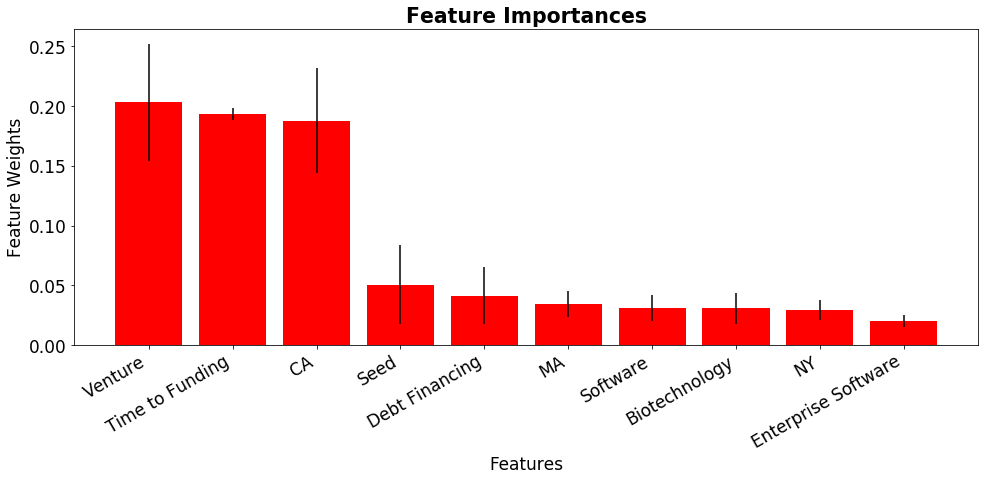

In [58]:
X =market_dummies.iloc[:,:20].join(state_dummies.iloc[:,:50]).join(clean_feat_df['time_to_funding']).join(funding_type_df)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
for f in range(10):
    print(f'{f+1}.  {X.columns[indices[f]]} feature Weight: {round(importances[indices[f]],2)}')

    
    
fig,ax = plt.subplots(figsize=(14,7))
ax.bar(range(0,10),importances[indices[:10]],color="r", yerr=std[indices[:10]], align="center")
plt.xticks(range(0,10), ['Venture', 'Time to Funding','CA','Seed','Debt Financing', 'MA', 'Software','Biotechnology','NY','Enterprise Software'],rotation=30,ha='right')
ax.set_xlabel('Features')
ax.set_ylabel('Feature Weights')
ax.set_title('Feature Importances',fontweight='bold')
plt.tight_layout()
plt.savefig('../images/feature_importances.png')

In [30]:
scores.mean()

0.6621324789784596

In [ ]:
len(indices)

In [ ]:
# class DataFrame(object):

#     def __init__(self,file_path):
#         """Create df object
#         Parameters
#         ----------
#         file_path: takes in a file path to raw data
#         """
#         self.file_path = file_path
        
#     def clean(self):
#         '''
#         Parameters
#             self: self
#         Returns
#             a cleaned df
#         '''
#         df = pd.read_csv(self.file_path,encoding='latin1')
#         df.dropna(inplace=True)
#         df.drop(['permalink','region','founded_month','founded_quarter'],axis=1,inplace=True)
#         df['founded_at'] = pd.to_datetime(df['founded_at'],errors='coerce')
#         df['first_funding_at']= pd.to_datetime(df['first_funding_at'],errors='coerce')
#         df['last_funding_at']= pd.to_datetime(df['first_funding_at'],errors='coerce')
#         df['founded_year'] = df['founded_year'].astype('int64')
#         df.drop(df[df['country_code']=='CAN'].index,inplace=True)
#         df['funding_total_usd'] = df[' funding_total_usd '].apply(lambda x: x.replace(' ',''))\
#             .apply(lambda x: x.replace(',',''))
#         df['funding_total_usd'] = df['funding_total_usd'].apply(lambda x: x.replace('-','0'))
#         df['funding_total_usd'] = df['funding_total_usd'].astype('int64')
#         df['market'] = df[' market '].apply(lambda x: x.replace(' ',''))
#         df.drop(' market ',axis=1,inplace=True)
#         df.drop(' funding_total_usd ',axis=1,inplace=True)
#         df.drop('country_code',axis=1,inplace=True)
#         df.drop('homepage_url',axis=1,inplace=True)
#         df.drop('name',axis=1,inplace=True)
#         return df
        

In [ ]:
df = DataFrame('../../../Downloads/investments_VC.csv').clean()

In [ ]:
accuracy_score(np.array([[0, 1], [1, 1]]), np.ones((2, 2))

In [ ]:
x = np.array([[0, 1], [1, 1],[0, 1], [0, 1]])

In [ ]:
x2 = np.ones((4, 2))

In [ ]:
accuracy_score(x,x2)

In [ ]:
funding_type_df

In [ ]:
X =market_dummies.iloc[:,:20].join(clean_feat_df['time_to_funding']).values
y=clean_feat_df['status'].values

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y)

regr = AdaBoostRegressor(n_estimators=100)
regr.fit(X_train,y_train)
y_predict = regr.predict(X_test)

In [ ]:
state_dummies = pd.get_dummies(clean_feat_df['state_code'])

In [ ]:
state_dummies.iloc[:,:50]

In [ ]:
x = np.arange(25, 51, 1).tolist()

In [ ]:
x

In [ ]:




# x = df['time_to_funding'].values
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled)

In [ ]:
y.sum()

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where

# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# # summarize the new class distribution
# counter = Counter(y)
# print(counter)
# # scatter plot of

In [ ]:
X.sum()

In [ ]:
y.sum()

In [ ]:
# markets_df = clean_feat_df['market'].value_counts().reset_index(name='counts')
# markets_df = markets_df.iloc[1:11,:]
# labels=markets_df['index']

# fig, ax = plt.subplots(figsize=(14,7))
# ax.pie(markets_df['counts'], labels=labels, autopct='%1.1f%%',
#         shadow=False, startangle=70)
# ax.axis('equal') 
# # ax.set_title('Market Splits')
# # plt.savefig('../images/market_split.png',dpi=500)


# # pie_df= clean_feat_df['status'].value_counts()\
# #         .rename_axis('status').reset_index(name='counts')
# #     pie_df['pct'] = pie_df['counts']/len(clean_feat_df)
# #     labels=pie_df['status']
# #     fig, ax = plt.subplots(figsize=(14,7))
# #     ax.pie(pie_df['pct'], explode=[0,0,.15], labels=labels, autopct='%1.1f%%',
# #             shadow=True, startangle=50)
# #     ax.axis('equal') 
# #     ax.set_title('Status')
# #     plt.savefig('../images/all_markets_pie.png',dpi=500)
# #     plt.close(